In [64]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import torchaudio.transforms as TT
import librosa
import os

In [65]:
dataset = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

directory = '/nas/home/jalbarracin/datasets/hrir_st'

for files in os.listdir(directory):
    f = os.path.join(directory, files)
    wave, sr = torchaudio.load(f, normalize=True)
    dataset.append(wave)

Using device: cuda


In [66]:
print(f"Dataset length: {len(dataset)}")
print(f"Sample channels and length: {dataset[0].shape}")

Dataset length: 3096
Sample channels and length: torch.Size([2, 256])


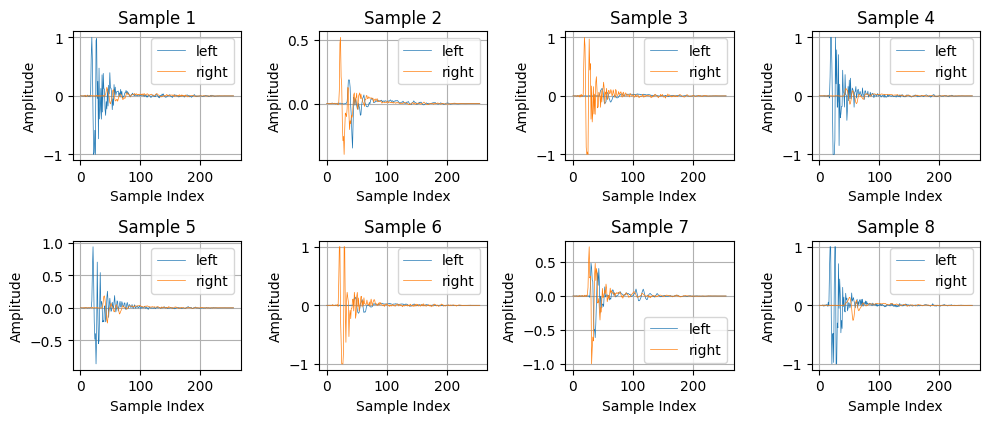

In [67]:
def show_waveforms(dataset, num_samples=20, cols=4):
    """ Plots some samples from the audio dataset """
    plt.figure(figsize=(10, 6)) 
    for i, item in enumerate(dataset):
        if i == num_samples:
            break
        if isinstance(item, tuple):
            waveform, _ = item
        else:
            waveform = item
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.plot(waveform[0].numpy(), label='left', linewidth=0.5)
        plt.plot(waveform[1].numpy(), label='right', linewidth=0.5)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()
show_waveforms(dataset, num_samples=8, cols=4)

In [68]:
def collate_fn(batch):
    # Assuming each element in batch is a tensor of shape (2, 256)
    return torch.stack(batch)

In [69]:
BATCH_SIZE = 1 # len(dataset) // 4
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn,
)

In [70]:
audio_test = next(iter(dataloader))[0]
print(audio_test.shape)

torch.Size([2, 256])


In [71]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return torch.clamp_(sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device),-1.0,1.0), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [72]:
def show_tensor_waveform(waveform):
    reverse_transforms = [
        lambda t: t.numpy(),        # Convert tensor to NumPy array
        lambda t: np.squeeze(t),    # Remove singleton dimensions
    ]

    # Take the first waveform of the batch
    if len(waveform.shape) == 3:
        waveform = waveform[0, :, :]

    for transform in reverse_transforms:
        waveform = transform(waveform)

     # Plot left channel (index 0)
    plt.plot(waveform[0], label="Left Channel")

    # Plot right channel (index 1)
    plt.plot(waveform[1], label="Right Channel")

    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.title("Waveform Visualization")
    #plt.legend()
    #plt.show()

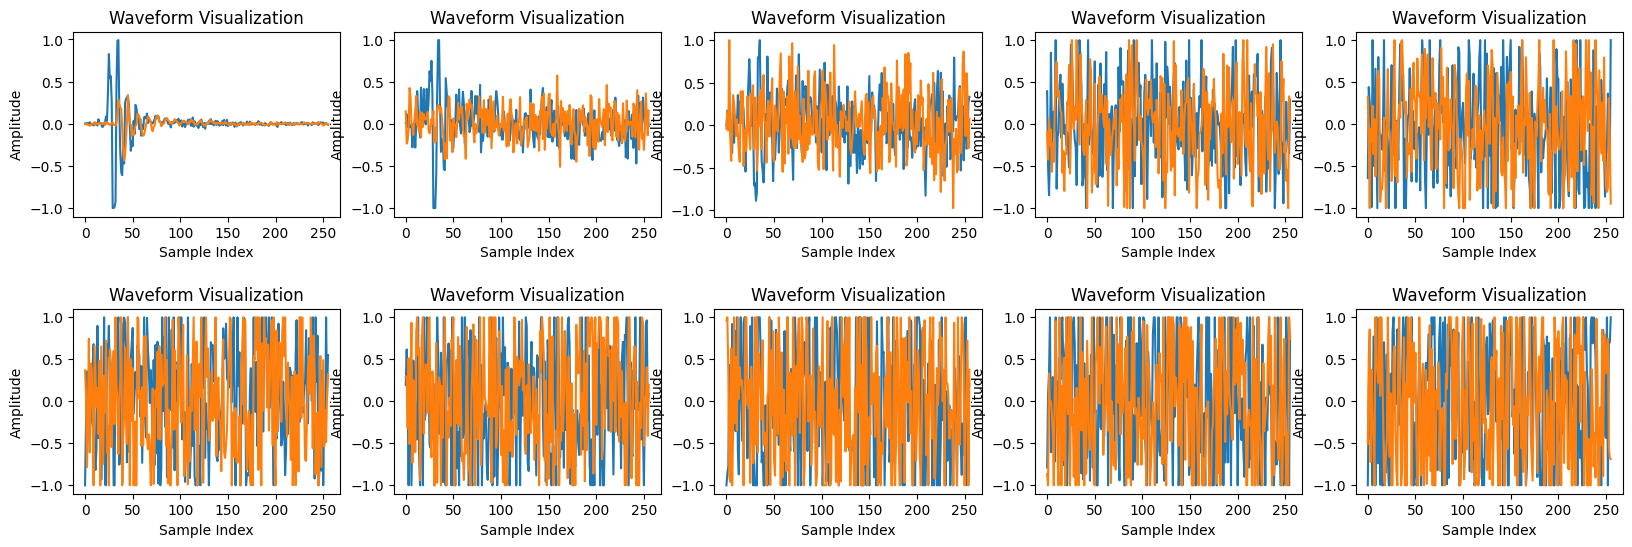

In [73]:
# Simulate forward diffusion
audio_test = next(iter(dataloader))[0]

plt.figure(figsize=(20,6))
plt.axis('off')
num_rows = 2
num_img_row = 5
num_images = num_rows * num_img_row
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    subplot_idx = int(idx / stepsize) + 1
    row = (subplot_idx - 1) // num_img_row + 1
    col = (subplot_idx - 1) % num_img_row + 1
    plt.subplot(num_rows, num_img_row, subplot_idx)
    au, noise = forward_diffusion_sample(audio_test, t)
    #print(au.shape)
    show_tensor_waveform(au)

plt.subplots_adjust(hspace=0.5)

In [89]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv1d(2 * in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Remove the last singleton dimension
        x = x.squeeze(2)
        
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x.unsqueeze(2))))  # Adjust here
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last dimension
        time_emb = time_emb.unsqueeze(-1)
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        audio_channels = 2  # Adjust for stereo audio
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 2  # Adjust for stereo audio
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv1d(audio_channels, down_channels[0], kernel_size=3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) \
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) \
                                  for i in range(len(up_channels) - 1)])

        # Output layer
        self.output = nn.Conv1d(up_channels[-1], out_dim, kernel_size=1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)  # Remove squeezing here
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        # Assuming final output layer is 1D
        return self.output(x)

# Example usage
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model


Num params:  18569314


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(128, 128, kernel_size=(4,), stride=(2,), padding=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (bnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (transform): Conv1d(256, 256, kernel_si

In [90]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    # Unsqueezing the channel dimension for mono audio
    noise_pred = model(x_noisy.unsqueeze(1), t)
    return F.l1_loss(noise, noise_pred)

In [91]:
AUDIO_SIZE = 256

@torch.no_grad()
def sample_timestep(audio, t):
    """
    Calls the model to predict the noise in the audio and returns 
    the denoised audio. 
    Applies noise to this audio, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, audio.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, audio.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, audio.shape)
    
    # Call model (current audio - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        audio - betas_t * model(audio, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, audio.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(audio)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_audio():
    # Sample noise
    audio = torch.randn((1, 2, AUDIO_SIZE), device=device)  # Adjust for stereo audio
    plt.figure(figsize=(15, 6))
    plt.axis('off')
    num_audios = 5
    stepsize = int(T / num_audios)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        audio = sample_timestep(audio, t)
        # Clip the audio to a reasonable range (-1 to 1)
        audio = torch.clamp(audio, -1.0, 1.0)
        
        if i % stepsize == 0:
            plt.subplot(1, num_audios, int(i / stepsize) + 1)
            # Assuming the first channel represents the left and the second channel represents the right
            show_tensor_waveform(audio[0][0].detach().cpu())  # Display left channel
            show_tensor_waveform(audio[0][1].detach().cpu())  # Display right channel
            torchaudio.save(f'generated_st_audio_{i}.wav', audio[0].cpu(), 44100)  # Save the stereo audio
    plt.show()


In [92]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 2   # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        x_input = batch[0].unsqueeze(1)  # Unsqueezing the channel dimension
        loss = get_loss(model, x_input, t)
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_audio()
            

    # Save model and optimizer states after each epoch
    checkpoint_path = f"/nas/home/jalbarracin/ddpm/checkpoints/12_nov_st/checkpoint_epoch_{epoch}.pt"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss.item(),
    }, checkpoint_path)

print("Training complete. Saved checkpoints.")


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [2, 1, 1, 256]